# Book for project submissions for the Coursera-Capstone

This book will include the algorithms to solve all problems of the coursera peer-reviewed assignment. 
The analysis is detailed so the answers to the assignment problems are highlighted with level 2 headings to save time to those who are not interested in the details. 

Use ctrl+f 'Answer to problem...' for quick lookup of the end results.

# Week 3 submission

The analysis of Toronto areas.

In [258]:
import geopy.geocoders

In [259]:
import folium

In [260]:
import pandas as pd
import numpy as np
import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
# import k-means from clustering stage
from sklearn.cluster import KMeans

print('Libraries imported.')

Libraries imported.


First the data needs to be scraped from Wikipedia with Pandas. Inspecting the object to find the where the relevant data is.

In [4]:
Tor_data_scraped = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M') 
print(type(Tor_data_scraped))
print(len(Tor_data_scraped))
print('1st item \n',type(Tor_data_scraped[0]) , Tor_data_scraped[0])
print('2nd item \n',type(Tor_data_scraped[1]),Tor_data_scraped[0])
print('3rd item \n',type(Tor_data_scraped[2]), Tor_data_scraped[0])

<class 'list'>
3
1st item 
 <class 'pandas.core.frame.DataFrame'>     Postal Code           Borough  \
0           M1A      Not assigned   
1           M2A      Not assigned   
2           M3A        North York   
3           M4A        North York   
4           M5A  Downtown Toronto   
..          ...               ...   
175         M5Z      Not assigned   
176         M6Z      Not assigned   
177         M7Z      Not assigned   
178         M8Z         Etobicoke   
179         M9Z      Not assigned   

                                         Neighbourhood  
0                                         Not assigned  
1                                         Not assigned  
2                                            Parkwoods  
3                                     Victoria Village  
4                            Regent Park, Harbourfront  
..                                                 ...  
175                                       Not assigned  
176                              

From the above we can see tat we have scraped a list of Dataframes. The first item seems to contain all the fields we want. So we clean the dataframe and prepare it for analysis.

In [5]:
Toronto_df = Tor_data_scraped[0]
Toronto_df = Toronto_df[Toronto_df['Borough'] != 'Not assigned'].reset_index(drop =True)
print(len(Toronto_df[Toronto_df['Neighbourhood'].str.upper() == 'Not assigned'.upper()])== 0)
Toronto_df.info()

True
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Postal Code    103 non-null    object
 1   Borough        103 non-null    object
 2   Neighbourhood  103 non-null    object
dtypes: object(3)
memory usage: 1.3+ KB


After ignoring the 'Not assigned' Boroughs as intructed in the guidlines, matching any casing differences by standardising to upper, we see that there are no 'Not assigned' Neighborhoods to be filled in with Borough names.

This is assuming that there are no spelling mistakes, or differntly coded missing values. There are no more Nulls in the DataFrame which can be seen from the info method output.



In [6]:
Toronto_DF = Toronto_df[Toronto_df['Neighbourhood'] != 'Not assigned']
print(Toronto_DF['Postal Code'].value_counts())
#there are no overlapping postal codes so the dataframe now is the same(except the exact index values) as the one in the assignment page.
Toronto_DF.head(11)

M4C    1
M4G    1
M5N    1
M5G    1
M4E    1
      ..
M5B    1
M7Y    1
M4V    1
M4N    1
M4B    1
Name: Postal Code, Length: 103, dtype: int64


,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


## Answer to problem 1

In [234]:
#number of rows in the dataframe
print(Toronto_DF.shape[0]) 

103


---------

In [235]:
import geocoder # import geocoder

# initialize your variable to None
lat_lng_coords = None
postal_code = Toronto_DF['Postal Code']

# loop until you get the coordinates
#while(lat_lng_coords is None):
g = geocoder.google('{}, Toronto, Ontario'.format(postal_code[1]))
lat_lng_coords = g.latlng
#REQUEST DENIED
g

<[REQUEST_DENIED] Google - Geocode [empty]>

Since my request for data was denied, after waiting for about 20 minutes I concluded that the while loop seems to be infinite(lat_lng_coords is never populated) so I am continuing with the CSV provided in the assignment.

I will be using pandas to read the CSV since this is the most straightforward.

In [236]:
geo = pd.read_csv('https://cocl.us/Geospatial_data')
geo

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
...,...,...,...
98,M9N,43.706876,-79.518188
99,M9P,43.696319,-79.532242
100,M9R,43.688905,-79.554724
101,M9V,43.739416,-79.588437


Since I have the geospacial data I just need to merge the two frames on postal code to get the final datarfame.

## Answer to problem 2

The merging is done on the 'Postal Code', since we identified that that is the unique key of both frames.

In [237]:
Toronto_geo = Toronto_DF.merge(geo, how = 'inner', on = 'Postal Code' )
Toronto_geo.head(11)

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills,43.745906,-79.352188
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


---------

We proceed with the analysis having collected all the geospacial data needed for the Foursquare API. There is the "only Boroughs that contain 'Toronto'" problem solved but commented out. I would like to use as much of the dataset as possible,because it would make the analysis a bit more interesting. 

In [261]:
#Only areas that contain the word Torronto problem
#Toronto_gdf =Toronto_geo[Toronto_geo['Borough'].str.contains('Toronto')].reset_index(drop = True)
Toronto_gdf = Toronto_geo
print(Toronto_gdf.shape)



(103, 5)


A total map of the area of interest is provided below to show unlabelled data.

In [262]:

latitude = 43.651070
longitude = -79.347015

map_Toronto= folium.Map(location=[latitude, longitude], zoom_start=9.5)
map_Toronto

for lat, lng, borough, neighborhood in zip(Toronto_gdf['Latitude'],Toronto_gdf['Longitude'], Toronto_gdf['Borough'],Toronto_gdf['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto


Creating data that the Kmeans will cluster by with the forsquare_API.

In [263]:
#Forsquare credentials
CLIENT_ID = 'XZGLPPX1CZNGLIHJ0DCOAQFPBETBD2HURQ0QIUULM05FI1MH' # your Foursquare ID
CLIENT_SECRET = 'A4KFWSFMPWVYVAVF3J130MLZOADPTEFIECSHG2QFDSAYRVLX' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 300
#Toronto_gdf



Below are the 2 handy functions from the lab, that will efficiently reitrieve venues and their categories for out cluster analysis.

In [264]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)#changed the limit manually
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [265]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Applying the above functions to get all the venues for the Torronto areas. The below code will print out all the neighborhoods that are included in the analysis, but this can be modified for analyses of larger geographical areas. 

In [243]:
Toronto_venues = getNearbyVenues(names=Toronto_gdf['Neighbourhood'],
                                   latitudes=Toronto_gdf['Latitude'],
                                   longitudes=Toronto_gdf['Longitude'], radius = 600
                                  )


Inspecting the dataframe to have an overview of the data.

In [266]:
print('Total number of venues: ', Toronto_venues.shape[0])
print('There are {} unique categories.'.format(len(Toronto_venues['Venue Category'].unique())))
Toronto_venues.groupby('Neighborhood').count()

Total number of venues:  2785
There are 293 unique categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,4,4,4,4,4,4
"Alderwood, Long Branch",11,11,11,11,11,11
"Bathurst Manor, Wilson Heights, Downsview North",22,22,22,22,22,22
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",28,28,28,28,28,28
...,...,...,...,...,...,...
"Willowdale, Willowdale East",51,51,51,51,51,51
"Willowdale, Willowdale West",5,5,5,5,5,5
Woburn,4,4,4,4,4,4


One hot encoding for the cluster analysis.

<b>NOTE:</b>

My version of python Auto-Alphabetises the columns so I had to find the 'Neighborhood' column position after inserting it(col_position)

In [267]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Toronto_onehot['Neighborhood'] = Toronto_venues['Neighborhood'] 
Toronto_onehot['Neighborhood']

# move neighborhood column to the first column 

col_position = list(Toronto_onehot.columns).index('Neighborhood')

fixed_columns = [Toronto_onehot.columns[col_position]] + list(Toronto_onehot.columns[:col_position]) + list(Toronto_onehot.columns[(col_position+1):])
Toronto_onehot = Toronto_onehot[fixed_columns]
#print(Toronto_onehot.shape)
print('This number should be 1 if there are no duplicate "Neighborhood" columns : ' , sum(sum([Toronto_onehot.columns == 'Neighborhood'])))
Toronto_onehot.head()

This number should be 1 if there are no duplicate "Neighborhood" columns :  1


,Neighborhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Then the frame needs to be grouped to get the desired feature list. The group dataframe matches the both the number of neighborhoods and the number of unique catefories from above, so no information was lost.

In [268]:
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()
print('Size confirmation: ', Toronto_grouped.shape)

Toronto_grouped

Size confirmation:  (96, 293)


,Neighborhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.035714,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.035714,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,"Willowdale, Willowdale East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.019608,...,0.0,0.0,0.0,0.019608,0.0,0.0,0.0,0.0,0.000000,0.0
92,"Willowdale, Willowdale West",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
93,Woburn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
94,Woodbine Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0


Numbre of top venues function from the lab.

In [269]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Getting the top 10 venues

In [278]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Toronto_grouped['Neighborhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Sandwich Place,Lounge,Breakfast Spot,Latin American Restaurant,Drugstore,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant
1,"Alderwood, Long Branch",Pizza Place,Gym,Gas Station,Coffee Shop,Pool,Pub,Convenience Store,Sandwich Place,Skating Rink,Pharmacy
2,"Bathurst Manor, Wilson Heights, Downsview North",Park,Bank,Coffee Shop,Sandwich Place,Sushi Restaurant,Supermarket,Bridal Shop,Shopping Mall,Diner,Middle Eastern Restaurant
3,Bayview Village,Japanese Restaurant,Bank,Chinese Restaurant,Café,Yoga Studio,Donut Shop,Distribution Center,Dive Bar,Dog Run,Doner Restaurant
4,"Bedford Park, Lawrence Manor East",Italian Restaurant,Coffee Shop,Sandwich Place,Restaurant,Greek Restaurant,Pub,Liquor Store,Comfort Food Restaurant,Butcher,Juice Bar
5,Berczy Park,Coffee Shop,Hotel,Seafood Restaurant,Restaurant,Café,Pub,Japanese Restaurant,Cocktail Bar,Italian Restaurant,Bakery
6,"Birch Cliff, Cliffside West",College Stadium,Skating Rink,Diner,General Entertainment,Café,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Dessert Shop
7,"Brockton, Parkdale Village, Exhibition Place",Coffee Shop,Café,Bakery,Breakfast Spot,Sandwich Place,Restaurant,Yoga Studio,Gift Shop,Food,Furniture / Home Store
8,"Business reply mail Processing Centre, South C...",Park,Burrito Place,Yoga Studio,Sandwich Place,Steakhouse,Beer Store,Brewery,Smoke Shop,Skate Park,Restaurant
9,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Terminal,Coffee Shop,Boat or Ferry,Airport Lounge,Rental Car Location,Bar,Harbor / Marina,Airport Gate,Airport Food Court


Since the number of clusters is arbitrary in this case I will apply 4 clusters to see if the neighborhoods cluster in any way according to the 4 compass directions. But this can be changed to any number dependent on what one is looking for.

In [279]:
kclusters = 5

Toronto_grouped_clustering = Toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_clustering)

neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Tor_merged = Toronto_gdf.rename(columns={"Neighbourhood": "Neighborhood"}, errors="raise")

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Tor_merged = Tor_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

#inspecting the dataframe before proceding
print(Tor_merged.info()) 
#Null rows
Tor_merged[Tor_merged['Cluster Labels'].isna()]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103 entries, 0 to 102
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Postal Code             103 non-null    object 
 1   Borough                 103 non-null    object 
 2   Neighborhood            103 non-null    object 
 3   Latitude                103 non-null    float64
 4   Longitude               103 non-null    float64
 5   Cluster Labels          100 non-null    float64
 6   1st Most Common Venue   100 non-null    object 
 7   2nd Most Common Venue   100 non-null    object 
 8   3rd Most Common Venue   100 non-null    object 
 9   4th Most Common Venue   100 non-null    object 
 10  5th Most Common Venue   100 non-null    object 
 11  6th Most Common Venue   100 non-null    object 
 12  7th Most Common Venue   100 non-null    object 
 13  8th Most Common Venue   100 non-null    object 
 14  9th Most Common Venue   100 non-null    ob

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
45,M2L,North York,"York Mills, Silver Hills",43.757490,-79.374714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52,M2M,North York,"Willowdale, Newtonbrook",43.789053,-79.408493,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,M1X,Scarborough,Upper Rouge,43.836125,-79.205636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There are 3 null cluster values in the dataset, as we can see that cluster labels are null, because there is no information about venues in these neighborhoods on the Foursquare API or there was a problem parsing. 

Nevertheless, the issue is found, and the rows will be dropped, because there are still 100 clustered neighborhoods to proceed with the analysis on this occasion. 



In [275]:
Tor_merged = Tor_merged.dropna(axis = 0 ,subset = ['Cluster Labels']).reset_index(drop = True)

#for looping the coming blocks of code it is best if clusters are of INT type
Tor_merged['Cluster Labels'] = Tor_merged['Cluster Labels'].astype(int)
print(Tor_merged.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Postal Code             100 non-null    object 
 1   Borough                 100 non-null    object 
 2   Neighborhood            100 non-null    object 
 3   Latitude                100 non-null    float64
 4   Longitude               100 non-null    float64
 5   Cluster Labels          100 non-null    int32  
 6   1st Most Common Venue   100 non-null    object 
 7   2nd Most Common Venue   100 non-null    object 
 8   3rd Most Common Venue   100 non-null    object 
 9   4th Most Common Venue   100 non-null    object 
 10  5th Most Common Venue   100 non-null    object 
 11  6th Most Common Venue   100 non-null    object 
 12  7th Most Common Venue   100 non-null    object 
 13  8th Most Common Venue   100 non-null    object 
 14  9th Most Common Venue   100 non-null    obj

Now that is is ensured that there are no nulls in the dataset an overview of the labels can be done. The overview of how many neighborhoods did the algorithm throw in each of the clusters it is a nice first look of the results. 

The length of color list(clr) has to match the number of cluster labels. I created a seperate list because I think it would be neat and tidy if the colours of the bar plot match the colours of the map below. I think it is also nice to have a horizontal grid lines to get a better sense of the numbers(persornal preference). 

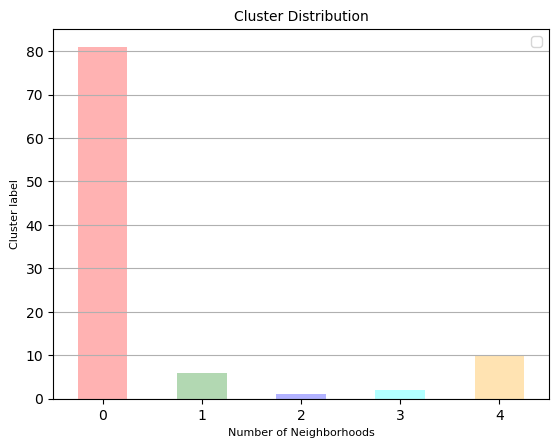

In [276]:
#Colour map
clr = ['red','green','blue', 'cyan', 'orange']


#getting frequency counts of each cluster label and formatting such that it could be plotted easily
dist = Tor_merged['Cluster Labels'].value_counts().to_frame().reset_index()
dist.columns = ['label', 'Num_of_hoods']
dist = dist.sort_values('label')


#plotting formatting stuff
dist.plot(kind = 'bar', x= 'label' , y = 'Num_of_hoods', alpha = 0.3 ,color = ['red','green','blue', 'cyan', 'orange'])
plt.grid(True, axis='y')
plt.xticks(rotation = 0)
plt.xlabel('Number of Neighborhoods',fontsize = 8)
plt.ylabel('Cluster label', fontsize = 8)
plt.title('Cluster Distribution', fontsize = 10 )
plt.legend([])

## Answer to problem 3

Finally one can map out the clusters with folium. I use the same color map(clr) as the bar plot above, to make the analysis tidier and more straightforward to understand.

In [274]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=9.5)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Tor_merged['Latitude'], Tor_merged['Longitude'], Tor_merged['Neighborhood'], Tor_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color= clr[cluster],
        fill=True,
        fill_color= clr[cluster],
        fill_opacity=0.3).add_to(map_clusters)
#show map       
map_clusters

## Examining the clusters

Below is a more detailed view of each of the neighborhooods in the cluster for any further analysis beyond the scope of the exercise. More data may uncover interesting insights of any common traits to each cluster(e.g. socio-economic data). 

Below are dataframe slices split by cluster.

In [227]:
Tor_merged.loc[Tor_merged['Cluster Labels'] == 0, Tor_merged.columns[[2,1] + list(range(5, Tor_merged.shape[1]))]]

,Neighborhood,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Victoria Village,North York,0,Hockey Arena,Pizza Place,Portuguese Restaurant,Coffee Shop,Intersection,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
2,"Regent Park, Harbourfront",Downtown Toronto,0,Coffee Shop,Bakery,Theater,Café,Park,Pub,Breakfast Spot,Mediterranean Restaurant,Bank,Hotel
3,"Lawrence Manor, Lawrence Heights",North York,0,Clothing Store,Furniture / Home Store,Vietnamese Restaurant,Accessories Store,Coffee Shop,Bowling Alley,Event Space,Cheese Shop,Gift Shop,Boutique
4,"Queen's Park, Ontario Provincial Government",Downtown Toronto,0,Coffee Shop,Sandwich Place,Café,Park,Yoga Studio,College Cafeteria,Smoothie Shop,Bubble Tea Shop,Burger Joint,Burrito Place
7,Don Mills,North York,0,Japanese Restaurant,Gym,Restaurant,Beer Store,Coffee Shop,Café,Clothing Store,Asian Restaurant,Chinese Restaurant,Art Gallery
...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,"First Canadian Place, Underground city",Downtown Toronto,0,Coffee Shop,Hotel,Café,American Restaurant,Seafood Restaurant,Asian Restaurant,Gym,Japanese Restaurant,Concert Hall,Theater
95,"The Kingsway, Montgomery Road, Old Mill North",Etobicoke,0,Liquor Store,Bakery,Park,Bar,Business Service,Coffee Shop,River,Pub,Doner Restaurant,Distribution Center
96,Church and Wellesley,Downtown Toronto,0,Coffee Shop,Japanese Restaurant,Gay Bar,Restaurant,Sushi Restaurant,Café,Liquor Store,Yoga Studio,Dance Studio,Bubble Tea Shop
97,"Business reply mail Processing Centre, South C...",East Toronto,0,Park,Burrito Place,Yoga Studio,Sandwich Place,Steakhouse,Beer Store,Brewery,Smoke Shop,Skate Park,Restaurant


In [228]:
Tor_merged.loc[Tor_merged['Cluster Labels'] == 1, Tor_merged.columns[[2,1] + list(range(5, Tor_merged.shape[1]))]]

,Neighborhood,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Parkwoods,North York,1,Food & Drink Shop,Bus Stop,Pet Store,Park,Yoga Studio,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant
21,Caledonia-Fairbanks,York,1,Park,Sporting Goods Shop,Women's Store,Gym,Bakery,Mexican Restaurant,Donut Shop,Discount Store,Distribution Center,Dive Bar
59,Lawrence Park,Central Toronto,1,Swim School,Bus Line,Park,Drugstore,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop
64,York Mills West,North York,1,Park,Gym Pool,Flower Shop,Convenience Store,Event Space,Electronics Store,Eastern European Restaurant,Fabric Shop,Falafel Restaurant,Dim Sum Restaurant
81,"Moore Park, Summerhill East",Central Toronto,1,Park,Tennis Court,Gym,Yoga Studio,Donut Shop,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run
89,Rosedale,Downtown Toronto,1,Park,Playground,Trail,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run


In [229]:
Tor_merged.loc[Tor_merged['Cluster Labels'] == 2, Tor_merged.columns[[2,1] + list(range(5, Tor_merged.shape[1]))]]

,Neighborhood,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
98,"Old Mill South, King's Mill Park, Sunnylea, Hu...",Etobicoke,2,Baseball Field,Yoga Studio,Diner,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant


In [230]:
Tor_merged.loc[Tor_merged['Cluster Labels'] == 3, Tor_merged.columns[[2,1] + list(range(5, Tor_merged.shape[1]))]]

,Neighborhood,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,"Malvern, Rouge",Scarborough,3,Fast Food Restaurant,Hardware Store,Spa,Donut Shop,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant
83,"Milliken, Agincourt North, Steeles East, L'Amo...",Scarborough,3,Fast Food Restaurant,Bakery,Park,Drugstore,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop


In [231]:
Tor_merged.loc[Tor_merged['Cluster Labels'] == 4, Tor_merged.columns[[2,1] + list(range(5, Tor_merged.shape[1]))]]

,Neighborhood,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,"Islington Avenue, Humber Valley Village",Etobicoke,4,Pharmacy,Café,Grocery Store,Bank,Shopping Mall,Doner Restaurant,Diner,Discount Store,Distribution Center,Dive Bar
8,"Parkview Hill, Woodbine Gardens",East York,4,Pizza Place,Gym / Fitness Center,Gastropub,Rock Climbing Spot,Café,Breakfast Spot,Pharmacy,Bank,Intersection,Athletics & Sports
11,"West Deane Park, Princess Gardens, Martin Grov...",Etobicoke,4,Pizza Place,Sandwich Place,Tea Room,Gift Shop,Chinese Restaurant,Dive Bar,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
39,Bayview Village,North York,4,Japanese Restaurant,Bank,Chinese Restaurant,Café,Yoga Studio,Donut Shop,Distribution Center,Dive Bar,Dog Run,Doner Restaurant
50,"Cliffside, Cliffcrest, Scarborough Village West",Scarborough,4,Wings Joint,Hardware Store,Pharmacy,Chinese Restaurant,Yoga Studio,Donut Shop,Diner,Discount Store,Distribution Center,Dive Bar
70,"Willowdale, Willowdale West",North York,4,Pizza Place,Pharmacy,Grocery Store,Bank,Coffee Shop,Donut Shop,Discount Store,Distribution Center,Dive Bar,Dog Run
75,"Kingsview Village, St. Phillips, Martin Grove ...",Etobicoke,4,Pharmacy,Supermarket,Mobile Phone Shop,Bank,Chinese Restaurant,Shopping Mall,Sandwich Place,Beer Store,Pizza Place,Drugstore
80,"Clarks Corners, Tam O'Shanter, Sullivan",Scarborough,4,Pizza Place,Pharmacy,Thai Restaurant,Italian Restaurant,Bank,Sandwich Place,Fried Chicken Joint,Discount Store,Chinese Restaurant,Gas Station
87,"South Steeles, Silverstone, Humbergate, Jamest...",Etobicoke,4,Grocery Store,Fast Food Restaurant,Pizza Place,Fried Chicken Joint,Discount Store,Beer Store,Sandwich Place,Hardware Store,Pharmacy,Electronics Store
88,"Steeles West, L'Amoreaux West",Scarborough,4,Fast Food Restaurant,Chinese Restaurant,Pizza Place,Grocery Store,Pharmacy,Breakfast Spot,Bank,Coffee Shop,Bubble Tea Shop,Sandwich Place
